In [1]:
##https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.datetime.html
##http://python-awips.readthedocs.io/en/latest/examples/generated/Profiler_Wind_Barb_Time-Series.html
from matplotlib.cm import get_cmap
from datetime import datetime, timedelta
from matplotlib.dates import date2num
#from metpy.units import units
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from netCDF4 import Dataset
from wrf import getvar,  ll_to_xy, ALL_TIMES, extract_times

##Query ESRL/PSD profiler data from Unidata AWIPS

In [4]:
def plotZM(data, x, y, z,plotOpt=None, modelLevels=None, surfacePressure=None):
    """Create a zonal mean contour plot of one variable
    plotOpt is a dictionary with plotting options:
      'scale_factor': multiply values with this factor before plotting
      'units': a units label for the colorbar
      'levels': use list of values as contour intervals
      'title': a title for the plot
    modelLevels: a list of pressure values indicating the model vertical resolution. If present,
        a small side panel will be drawn with lines for each model level
    surfacePressure: a list (dimension len(x)) of surface pressure values. If present, these will
        be used to mask out regions below the surface
    """
    # explanation of axes:
    #   ax1: primary coordinate system latitude vs. pressure (left ticks on y axis)
    #   ax2: twinned axes for altitude coordinates on right y axis
    #   axm: small side panel with shared y axis from ax2 for display of model levels
    # right y ticks and y label will be drawn on axr if modelLevels are given, else on ax2
    #   axr: pointer to "right axis", either ax2 or axm

    if plotOpt is None: plotOpt = {}
    labelFontSize =6  #"small"
    # create figure and axes
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    # scale data if requested
    scale_factor = plotOpt.get('scale_factor', 1.0)
    pdata = data * scale_factor
    # determine contour levels to be used; default: linear spacing, 20 levels
    clevs = plotOpt.get('levels', np.linspace(data.min(), data.max(), 20))
    # map contour values to colors
    norm=matplotlib.colors.BoundaryNorm(clevs, ncolors=256, clip=False)
    # draw the (filled) contours
    contour = ax1.contourf(x, y, pdata, levels=clevs, norm=norm)
    # mask out surface pressure if given
    if not surfacePressure is None:
        ax1.fill_between(x, surfacePressure, surfacePressure.max(), color="white")
    # add a title
    title = plotOpt.get('title', 'Vertical cross section')
    ax1.set_title(title)
    # add colorbar
    # Note: use of the ticks keyword forces colorbar to draw all labels
    fmt = matplotlib.ticker.FormatStrFormatter("%g")
    cbar = fig.colorbar(contour, ax=ax1, orientation='horizontal', shrink=0.8,
                        ticks=clevs, format=fmt)
    cbar.set_label(plotOpt.get('units', ''))
    for t in cbar.ax.get_xticklabels():
        t.set_fontsize(labelFontSize)
    # set up y axes: log pressure labels on the left y axis, altitude labels
    # according to model levels on the right y axis
    #plt.axes().get_yaxis().set_visible(False)
    #ax1.yaxis.set_visible(False)
    ax1.set_ylabel("Pressure [hPa]")
    ax1.set_yscale('log')
    ax1.set_ylim(10.*np.ceil(y.max()/10.), y.min()) # avoid truncation of 1000 hPa
    #subs = [1,2,5]
    if y.max()/y.min() < 30.:
        subs = [1,2,3,4,5,6,7,8,9]
    print(subs)
    #y1loc = matplotlib.ticker.LogLocator(base=10., subs=subs)
    #ax1.yaxis.set_major_locator(y1loc)
    #fmt = matplotlib.ticker.FormatStrFormatter("%g")
    #ax1.yaxis.set_major_formatter(fmt)
    for t in ax1.get_yticklabels():
        t.set_fontsize(labelFontSize)
    # calculate altitudes from pressure values (use fixed scale height)
    #z0 = 8.400    # scale height for pressure_to_altitude conversion [km]
    #altitude = z0 * np.log(1015.23/y)
    altitude = z
    # add second y axis for altitude scale
    ax2 = ax1.twinx()
    # change values and font size of x labels
    ax1.set_xlabel('Time [UTC]')
    ax1.tick_params(axis='both', which='major', labelsize=8,rotation=15)
    ax1.tick_params(axis='both', which='minor', labelsize=8,rotation=15)
    #xloc = matplotlib.ticker.FixedLocator(np.arange(-90.,91.,30.))
    #ax1.xaxis.set_major_locator(xloc)
    for t in ax1.get_xticklabels():
        t.set_fontsize(labelFontSize)
    # draw horizontal lines to the right to indicate model levels
    if not modelLevels is None:
        pos = ax1.get_position()
        axm = fig.add_axes([pos.x1,pos.y0,0.02,pos.height], sharey=ax2)
        axm.set_xlim(0., 1.)
        axm.xaxis.set_visible(False)
        #axm.yaxis.set_visible(False)
        modelLev = axm.hlines(altitude, 0., 1., color='0.5')
        axr = axm     # specify y axis for right tick marks and labels
        # turn off tick labels of ax2
        for t in ax2.get_yticklabels():
            t.set_visible(False)
        label_xcoor = 3.7
    else:
        axr = ax2
        label_xcoor = 1.05
    axr.set_ylabel("Altitude [km]")
    #axr.yaxis.labelpad = 50
    #axr.yaxis._axinfo['label']['space_factor'] = 2.0
    axr.yaxis.set_label_coords(label_xcoor, 0.5)
    axr.set_ylim(altitude.min(), altitude.max())
    yrloc = matplotlib.ticker.MaxNLocator(steps=[1,2,5,10])
    axr.yaxis.set_major_locator(yrloc)
    axr.yaxis.tick_right()
    for t in axr.yaxis.get_majorticklines():
        t.set_visible(False)
    for t in axr.get_yticklabels():
        t.set_fontsize(labelFontSize)
    # show plot
    plt.savefig("all1.png",dpi=600,bbox_inches='tight')

<xarray.DataArray 'pressure' (bottom_top: 23)>
array([997.9678 , 988.8756 , 975.2359 , 952.5023 , 920.69464, 884.37726,
       843.565  , 798.262  , 752.99835, 707.7681 , 662.59125, 617.45966,
       572.3614 , 527.2955 , 482.2598 , 437.2511 , 392.26303, 347.28253,
       302.3113 , 257.34738, 212.38918, 167.43457, 122.4815 ], dtype=float32)
Coordinates:
    XLONG         float32 120.12601
    XLAT          float32 36.294476
    XTIME         float32 1440.0
    Time          datetime64[ns] 2018-06-11
    latlon_coord  object CoordPair(lat=36.067, lon=120.390)
Dimensions without coordinates: bottom_top
Attributes:
    FieldType:      104
    MemoryOrder:    XYZ
    description:    pressure
    units:          hPa
    stagger:        
    coordinates:    XLONG XLAT XTIME
    projection:     LambertConformal(stand_lon=119.0, moad_cen_lat=37.0000038...
    _FillValue:     9.96921e+36
    missing_value:  9.96921e+36
[1, 2, 3, 4, 5, 6, 7, 8, 9]


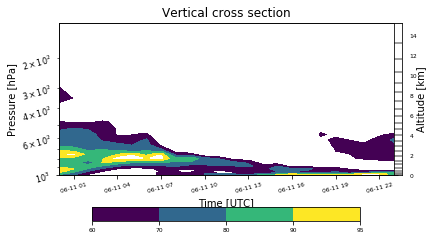

In [9]:
ncfile = Dataset("wrfout_d04_2018-06-11_00:00:00")
x_y = ll_to_xy(ncfile, '36.067', '120.390')
x=x_y[0]
y=x_y[1]
#wrftime=extract_times(ncfile,timeidx=ALL_TIMES,do_xtime=True)
wrftime=extract_times(ncfile,timeidx=ALL_TIMES)
p = getvar(ncfile, "pressure",timeidx=ALL_TIMES,squeeze=False)[0,:,x,y]
print(p)
#p = getvar(ncfile, "pressure")[:,:,x,y]
#pblh = getvar(ncfile, "PBLH",timeidx=ALL_TIMES,squeeze=False)[:,x,y]
times = getvar(ncfile, "times",timeidx=ALL_TIMES,squeeze=False)
#times = getvar(ncfile, "XTIME")
heights = getvar(ncfile, "z", units="km",timeidx=ALL_TIMES,squeeze=False)[0,:,x,y]
u = getvar(ncfile, "ua", units="kt",timeidx=ALL_TIMES,squeeze=False)[:,:,x,y]
v = getvar(ncfile, "va", units="kt",timeidx=ALL_TIMES,squeeze=False)[:,:,x,y]
rh = getvar(ncfile, "rh",timeidx=ALL_TIMES,squeeze=False)[:,:,x,y]

#wspd = getvar(ncfile, "wspd_wdir", units="kts")[0,:]
#fig = plt.figure(figsize=(16,7))
#cmap=plt.cm.RdYlGn_r
# Build arrays
# Convert u,v components to knots and transpose arrays to match t,hn
#u = (np.asarray(u, dtype=np.float32) * units('m/s')).to('knots').T
#v = (np.asarray(v, dtype=np.float32) * units('m/s')).to('knots').T
P, T = np.meshgrid(p,wrftime)
#T, H = np.meshgrid(wrftime,heights)
C = np.sqrt(u**2 + v**2)
#for caculate
modelLevels=[996.89386 , 987.8165  , 974.2029  , 951.5156  , 919.76404 , 883.50903 ,
       842.7532  , 797.48755 , 752.2567  , 707.08185 , 661.9632  , 616.8923  ,
       571.85724 , 526.8514  , 481.87424 , 436.92123 , 391.98193 , 347.05316 ,
       302.12985 , 257.2098  , 212.29172 , 167.37494 , 122.458336]
plotZM(rh, T, P, heights,plotOpt={"levels":[60,70,80,90,95]}, modelLevels=modelLevels)


In [ ]:
#fig, ax = plt.subplots()
#xy=ax.barbs(t, h, u, v)
#ax.title.set_text("test_profile")
# Make the contour plot
#rh_contours=ax.contourf(T,H,rh, levels=[60,70,80,90,95],cmap=get_cmap("Blues"))
# Add the color bar
#plt.colorbar(rh_contours)
#xy=ax.barbs(T, H, u, v, length=4.5,fill_empty=False, rounding=False,sizes=dict(emptybarb=0.25, spacing=0.4, height=0.2),linewidth=1)
#ax.xaxis_date()
#ax.set_xlim(times[0]-timedelta(hours=1), times[-1]+timedelta(hours=1))
#ax.set_xlim(wrftime[0], wrftime[-1])
#ax.set_xlim(wrftime[0]-np.timedelta64(30, 'm'), wrftime[-1]-np.timedelta64(30, 'm'))
#ax.set_xlim(wrftime[0]-np.timedelta64(1, 'h'), wrftime[-1]+np.timedelta64(1, 'h'))
#ax.set_ylim(0,10000)
#ax.tick_params(axis='both', which='major', labelsize=8,rotation=45)
#ax.grid(axis='x', which='major', alpha=0.5)
#ax.grid(axis='y', which='major', linestyle=':')
#plt.gca().invert_xaxis()
#plt.show()


##https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.datetime.html
##http://python-awips.readthedocs.io/en/latest/examples/generated/Profiler_Wind_Barb_Time-Series.html